In [147]:
import numpy as np
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA

import plotnine as pn

import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 1. The data and problem

For this lesson, we'll work with a new dataset of unknown origin (for the moment). 

In a not too unbelievable scenario, imagine that your boss has given you these data and said, "I don't really know what all of this stuff means, but I need you to model this and get me a model to predict $y$ using these data!", and of course they add, "I need this by the end of the day!"
![Drawing of a boss and person at computer](images/the_boss_small.jpg)


Let's load the data and start looking at it...

In [148]:
df = pd.read_csv('data/regularization.csv')

In [149]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,0.126504,0.477706,0.313475,0.514386,0.743750,0.234681,0.671997,0.270976,0.519267,0.361153,...,0.571807,0.281180,0.814374,0.527172,0.550691,0.021509,0.028173,0.837283,0.261703,4.077128
1,0.121590,0.483381,0.724387,0.818556,0.872479,0.441711,0.795640,0.474486,0.157817,0.251904,...,0.403155,0.372762,0.226465,0.002351,0.089564,0.913374,0.911584,0.784988,0.035362,4.981252
2,0.698551,0.036947,0.723721,0.459921,0.602351,0.560279,0.028867,0.414398,0.104540,0.906528,...,0.960674,0.529909,0.911473,0.828246,0.468373,0.582552,0.527382,0.470915,0.756324,6.649698
3,0.198011,0.724938,0.713586,0.493570,0.812774,0.665962,0.496994,0.145470,0.929903,0.299357,...,0.370109,0.862206,0.275417,0.717374,0.265629,0.952450,0.387913,0.477727,0.566269,6.034292
4,0.160674,0.462549,0.399120,0.062895,0.933785,0.942120,0.269115,0.780801,0.452808,0.047896,...,0.766598,0.838162,0.351654,0.207323,0.760390,0.860970,0.993952,0.417981,0.991003,7.588461


What should we do with this? We have 20 $x$ variables and 50 observations of those variables. How can we build a good predictive model for these data?

Where do we start?

Once we're ready to start looking at models, how do we select variables?

### Number of possible models

As a bit of an aside, model selection quickly blows up if we want to try all possible combinations. The table below shows the number of models that would need to be evaluated for $p$ features or predictors.

$p$ (number of predictors): | 1      | 2     | 10    | 20    | 40    | 100 
--------------------------|--------|---------|-------|-------|-------|-----
No of models for $p$ predictors| 2   |  4    | 1,024 | 1,0448,576| 1.1 X 10<sup>12</sup> | 1.3 X 10<sup>30</sup>
Add square of each predictor | 4 | 16 | 1,048,576 | 1.1 X 10<sup>12</sup> | 1.2 X 10<sup>24</sup> | 1.6 X 10<sup>60</sup>
Add pairwise interactions | 2 | 5 | 3.6 X 10<sup>13</sup> | 1.6 X 10<sup>57</sup> | 6.4 X 10<sup>234</sup> | ? 🤯 

**Fun fact:** Estimated number of atoms in the observable universe: ~10<sup>80</sup>

So...with 20 features, we are approaching the number of atoms in the uniSverse...

Somehow need to control for the number of parameters in our model!


## 2. Multiple linear regression

Let's explore multiple linear regression first to see what happens. _Note that, in the interest of time, I am leaving out exploratory data analyses and visualizations, which is where you should start!_

In [150]:
# Get the dataset ready
X = df.drop(columns = ['y'])
y = df['y']
 
# Create and fit a simple LinearRegression model
model = LinearRegression()
model.fit(X,y)


def mse(model, X, y):
    y_hat = model.predict(X)
    err = np.mean((y - y_hat)**2)
    return err

print('R^2:', model.score(X, y), 'MSE:', mse(model, X, y))

R^2: 0.9679699534659556 MSE: 0.07828974536159017


Now that we've got a model, let's use 5-fold cross-validation to estimate how well it will work for new (i.e., non-training) data.

In [151]:
kf = KFold(n_splits=5)

res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = np.mean(res)
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = np.mean(res)

print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

c-v R^2: 0.7734350974615247 c-v MSE: 0.38341921219406266


## 3. Lasso regularization

Remember that a model that is too complex, we tend to overfit the training data and get high variance, and if it's not complex enough, we underfit the training data and get high bias. Our goal is to find the model with just enough complexity. We can try to do this as part of the model optimization procedure.

So far, we've user the $MSE$ as our loss function. And our models look something like this:

$$ \hat{y} = b_0 + b_{1}x_{1} + b_{2}x_{2} + \ldots + b_{p}x_{p} $$

Let's define:  $\ell_1 penalty = \lambda \sum_{i=1}^{p} |b_{p}|$

And then we can make a new loss function that is: 

   $$  loss = MSE +  \lambda \sum_{i=1}^{p} |b_{p}|$$

As the coefficient for a feature increases, the $\ell_1 penalty$ also increases. If the model can push the $b$ for a feature to 0, that feature drops out of the model. By adjusting $\lambda$, we can adjust the effect of the $\ell_1 penalty$.

This is known as the Lasso, short for **l**east **a**bsolute **s**hrinkage and **s**election **o**perator.

Okay, so let's see what the lasso ($\ell_1$-regularized regression) does with these data.  We can use scikit-learn's `Lasso` estimator for this.  Note that scikit-learn uses `alpha` for the name of the parameter referred to as $\lambda$ virtually everywhere else (perhaps because `lambda` is a reserved word in Python).

As a general practice, you should always **make sure that your predictor variables are on the same scale when fitting a regularized regression model**.  We can have `Lasso` do this for us automatically by passing `normalize=True` when we create the `Lasso` object.

In [152]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01))
])

model.fit(X,y)
print(model.named_steps['lasso'].coef_ / model.named_steps['scaler'].scale_)


res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

[ 0.          2.07531097 -0.07765883  2.955528    0.01120125  0.19594985
  0.          0.04131297  0.15227467  0.09464139 -0.05563188  0.10460274
 -0.04104897  0.32482676 -0.06779785  0.47211508 -0.16832385  1.02321673
 -0.          4.28411995]
c-v R^2: 0.8600054286944238 c-v MSE: 0.25951580066352337


## 4. Ridge regression

Another method with similar goals, but different results is known as ridge regression. This uses what is referred to as the $\ell_1 penalty$

Let's define:  $\ell_2 penalty = \lambda \sum_{i=1}^{p} b_{p}^{2}$

Again, we can add the $\ell_1 penalty$ to the $MSE$.

Let's see what happens if we use ridge regression ($\ell_2$-regularized regression) with these data.  We can use scikit-learn's `Ridge` estimator to do this, and again, don't forget to make sure that your predictor variables are on the same scale.

All we need to do is copy the code from above and change `Lasso` to `Ridge` in the `model` line. The $\lambda$/`alpha` values have different effects.

In [153]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

model.fit(X,y)
print(model.named_steps['ridge'].coef_ / model.named_steps['scaler'].scale_)


res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

[ 0.09531273  2.05605168 -0.10642754  2.9951993   0.07563958  0.27413443
  0.02878165  0.06294739  0.22054062  0.11140858 -0.1273955   0.16130407
 -0.09155563  0.39916988 -0.10958678  0.54319753 -0.18986193  1.04649947
 -0.09828673  4.20133833]
c-v R^2: 0.7800314571282306 c-v MSE: 0.39191244382243856


## 5. How does $\lambda$ influence the parameter estimates?

Before we move on, let's take a closer look at how changing lambda influences the parameter estimates for both the lasso and ridge regression.

**Affect of $\lambda$ in Lasso Regression**

![Graph showing how the features drop out as lambda is increased with Lasso. 4 key features are highlighted](images/Lasso_feature_dropout.png)

**Affect of $\lambda$ in Ridge Regression**

![Graph showing how the features drop out as lambda is increased with Ridge. 4 key features are highlighted](images/Ridge_feature_dropout.png)


Lasso and ridge regression are examples of *regularization* or *shrinkage* methods, because they regularize/constrain the parameter estimates by shrinking them towards 0.

## 6. Choosing $\lambda$ and a modeling procedure

How should we choose the "best" value of $\lambda$ for the lasso or ridge regression?  How should we decide whether to use the lasso or ridge regression?  What ideas do you have?

In [154]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lassoCV', LassoCV())
])

model.fit(X,y)
print(model.named_steps['lassoCV'].coef_ / model.named_steps['scaler'].scale_)
print(f"Lambda: {model.named_steps['lassoCV'].alpha_}")

res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

[-0.          1.75308926  0.          2.56644637 -0.          0.04514838
  0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.39082245 -0.          0.70328889
  0.          3.97175774]
Lambda: 0.06800373121782305
c-v R^2: 0.8913493059968791 c-v MSE: 0.22966885202406004


In [155]:
lambdas = np.geomspace(0.1, 10, 100) # Unlike LassoCV, we need to provide the lambds, here we use a logarithmic scale.
                                    # Note that we need to update the search range--0.001 should be good in the end.

model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridgeCV', RidgeCV(alphas=lambdas))
])

model.fit(X,y)
print(model.named_steps['ridgeCV'].coef_ / model.named_steps['scaler'].scale_)
print(f"Lambda: {model.named_steps['ridgeCV'].alpha_}")

res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

[ 0.1079782   2.12304809 -0.1257682   3.07907437  0.10617551  0.25588553
  0.01914163  0.07295063  0.22561052  0.12119058 -0.11362664  0.19862652
 -0.11244737  0.43092648 -0.12883634  0.51171208 -0.20553653  1.09218396
 -0.08187802  4.28795444]
Lambda: 0.40370172585965547
c-v R^2: 0.7796457715211536 c-v MSE: 0.38131103114121356


## 7. Why/how do these methods work? Is one better than the other?

We'll start by revealing where the data we've been modeling actually came from, which will give us some insight into how these methods work.  Then we'll dig a little deeper into how these methods are able to decrease the expected test error.

These data were generated using: $y=1+ 2x_2 + 3x_4 + x_{18} + 4x_{20} + \epsilon ;    Var[\epsilon = 0.4] $

Look back the coefficients Lasso selected. Quite amazing!

### Returning to the bias-variance trade-off

The graph below shows the estimated test $MSE$ for models fit to data generated with the process used to generate the data we used in red. In blue is the Bias estimate and in green the variance. The vertical dashed line is the selected $\lambda$

![Graph of the estimated test MSE for models fit to data generated with the process used to generate the data we used in red. In blue is the Bias estimate and in green the variance.](images/Lasso_Bias-Variance_trade-off.png)
 
Notice that the model selected by Lasso does have bias! But we are trading a big reduction in variance for a small increase in bias.


### Key points to remember:

* The Lasso can drive coefficients to 0; thus, it can perform _feature selection_.
* Ridge regression constrains coefficient values (_shrinks_ them), but does not remove them from the model.

Which is best depends on your data and the goals of the analysis. In our case, most of the parameters were just noise, so Lasso performed better. If all of the parameters really played into generating the data, Ridge regression likely would have done better. **It depends on the data!**

## 8. Other methods

There are many other methods available for model/feature selection.  If you've had a statistics course, you've no doubt learned some of them.

Unfortunately, we don't have time to cover any of these alternative methods in detail in this course.  I will mention, though, that _dimensionality reduction_ is another widely used, general approach to dealing with model complexity and certainly worth learning about.  _Principle components regression_ is one example of this approach. One downside is that the models are less interpretable.

Another method I should mention is the _elastic net_, which combines $\ell_1$ and $\ell_2$ penalties into a single fitting procedure and can benefit from the desirable properties of both the lasso and ridge regression.

## 9. Data analysis lab

Now, put together everything that you've learned over the last few units (prediction error, bias and variance; methods for estimating test/prediction error; regularization techniques) and apply it to a data analysis problem.  Returning to the diabetes dataset, your goal is to create a machine learning model that can accurately predict the diabetes risk.

#### Student : Shayan Ahmed (UFID : 25467342, email: shayanahmed@ufl.edu)
Note : This notebook is a joint submission with Nicholas Marotta (UFID : 77036562, email: marottanicholas@ufl.edu) 

In [156]:
#Loading the dataset
from sklearn.datasets import load_diabetes
diabetics = load_diabetes()

In [157]:
# Creating the dataframe
def initialise_df() :
    column_name = diabetics.feature_names
    df = pd.DataFrame(diabetics.data)
    df.columns = column_name

    target = diabetics.target

    df['target'] = target.tolist()

    return df

df = initialise_df()

#Inspecting the head of the dataset
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [158]:
#Summary statistics
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


#### EDA and Data Visualization

In [159]:
#Missing values % in the dataset
df.isnull().sum() / df.shape[0] * 100

age       0.0
sex       0.0
bmi       0.0
bp        0.0
s1        0.0
s2        0.0
s3        0.0
s4        0.0
s5        0.0
s6        0.0
target    0.0
dtype: float64

No missing values are observed in the data, hence there is no need for data imputation

In [160]:
# Finding correlation between the features and the target variable
df.corr()['target']

age       0.187889
sex       0.043062
bmi       0.586450
bp        0.441482
s1        0.212022
s2        0.174054
s3       -0.394789
s4        0.430453
s5        0.565883
s6        0.382483
target    1.000000
Name: target, dtype: float64

On a surface level, some features like sex show weak correlation with the target, while features like bmi and s5 have somewhat higher correlation

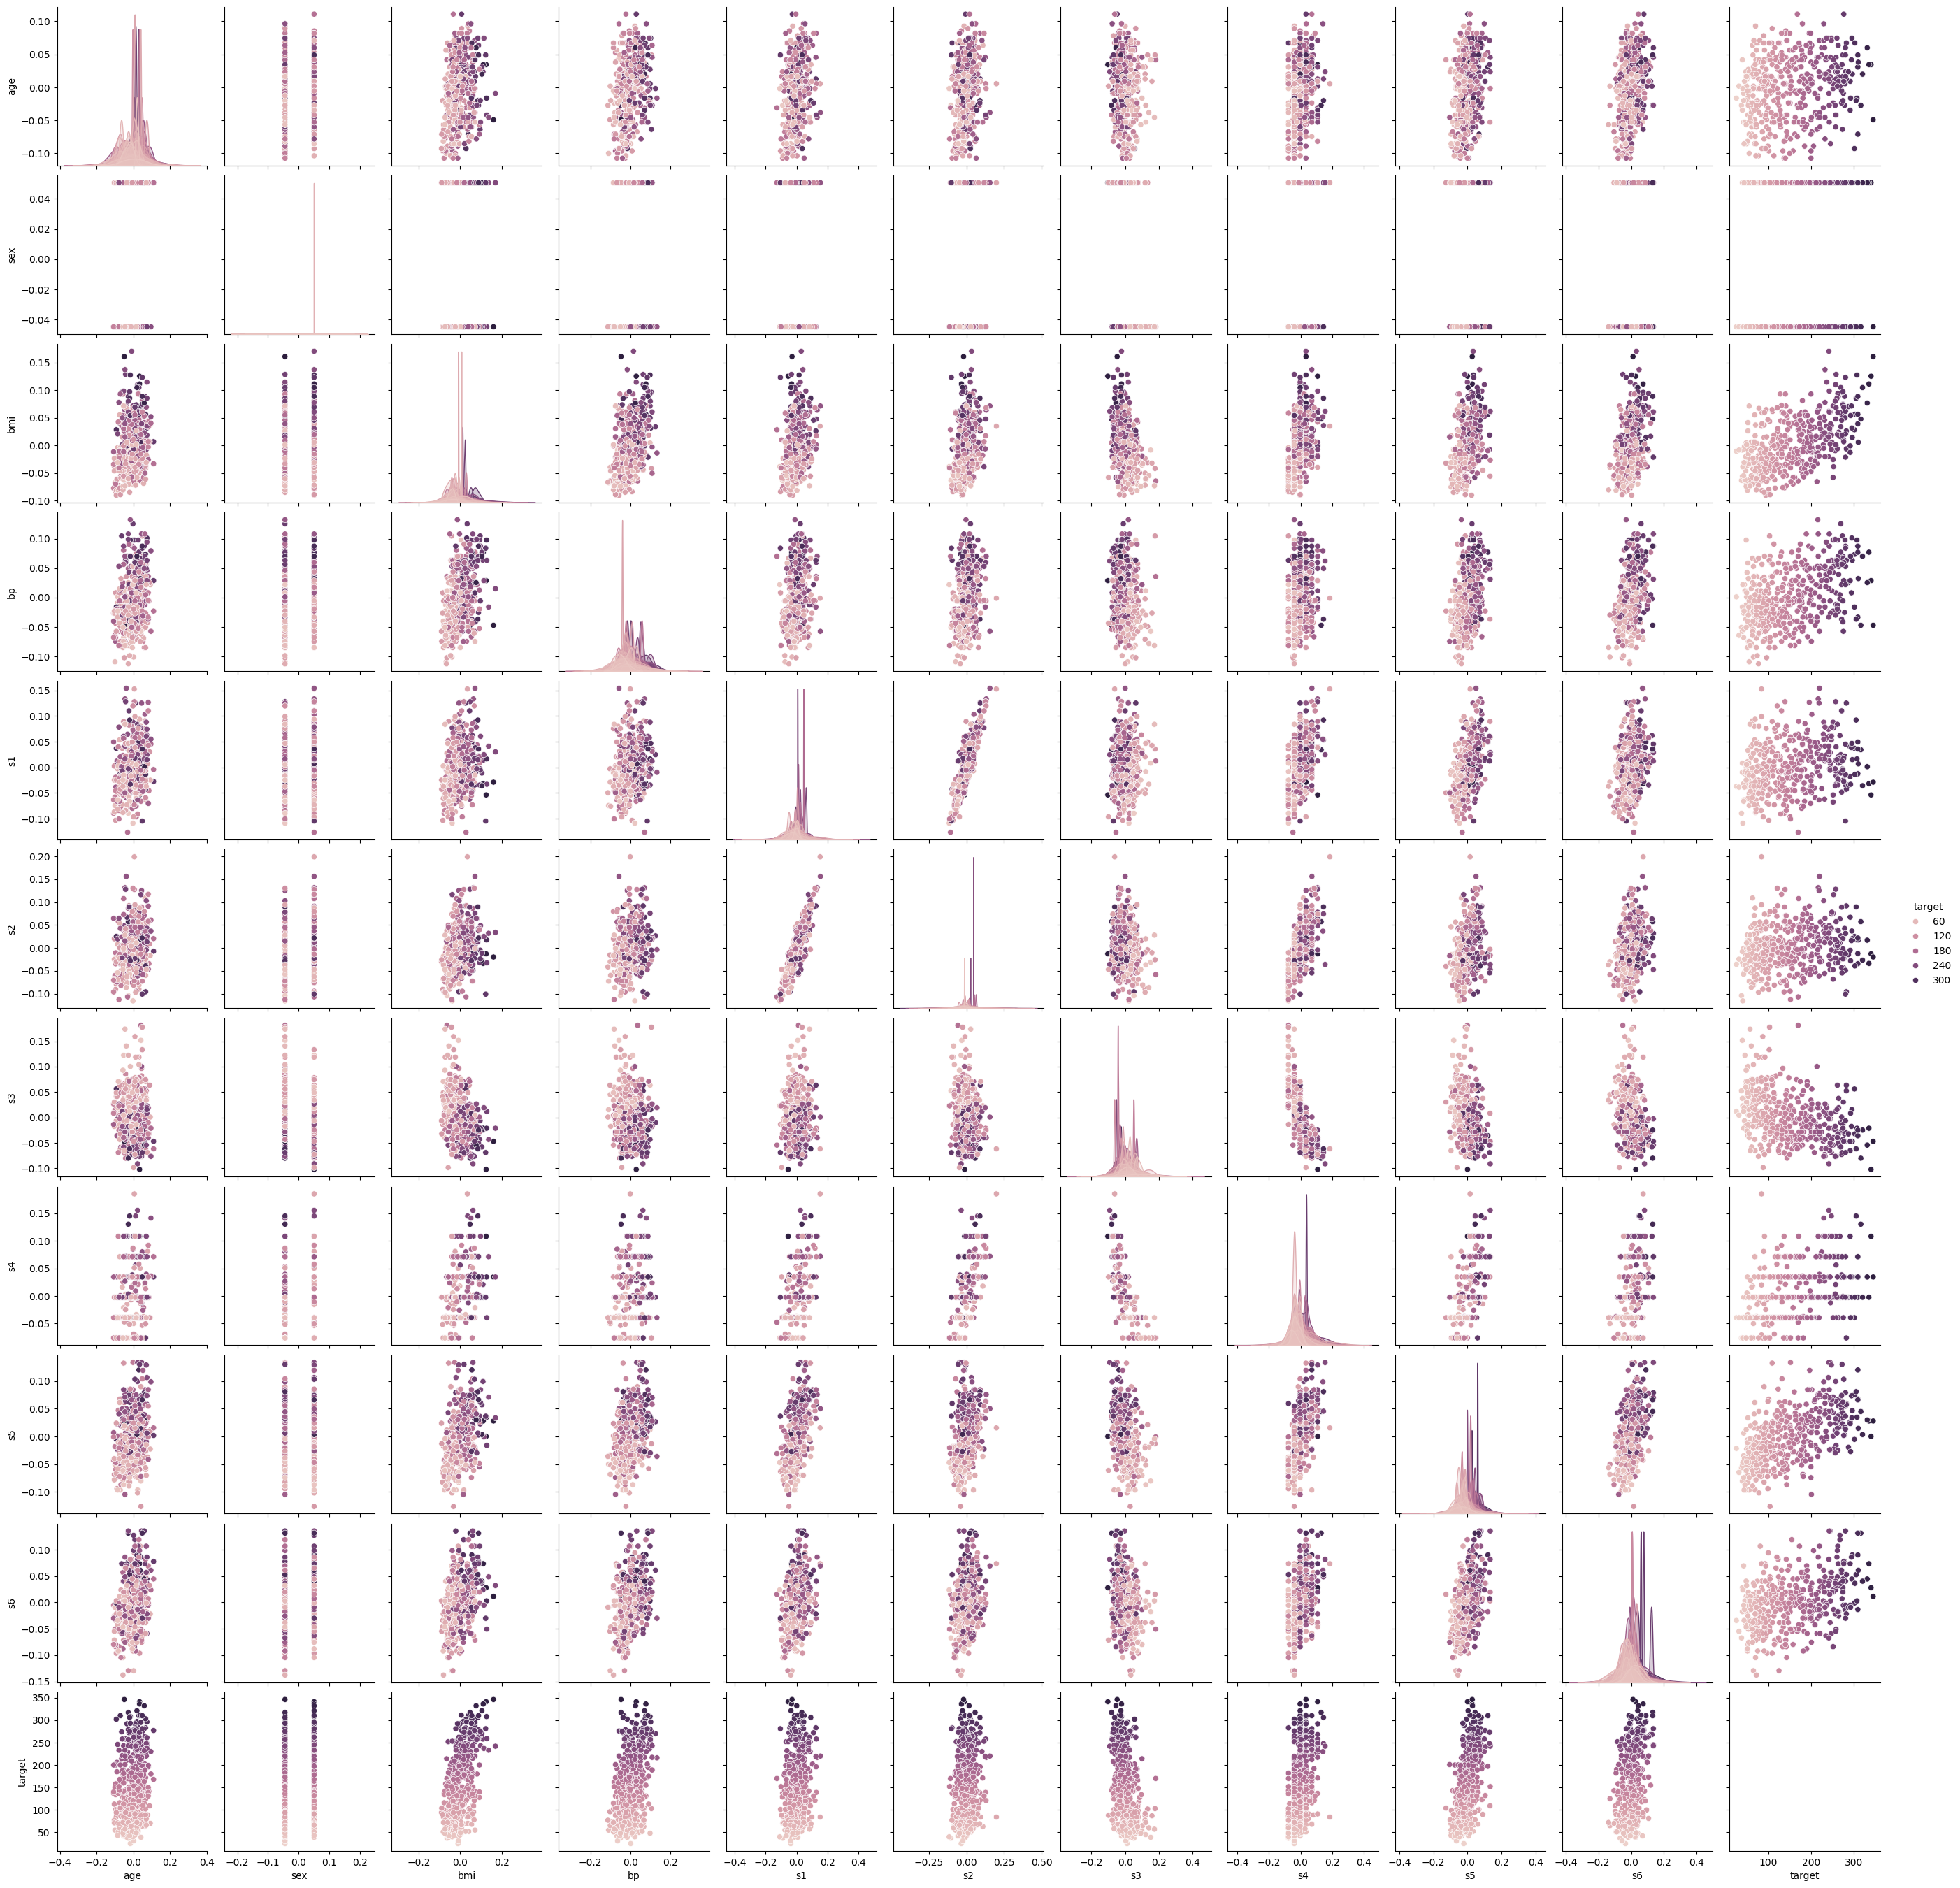

In [161]:
# Pairplot between each dataframe columns
sns.pairplot(df, x_vars=df.columns, y_vars=df.columns, hue='target')
plt.show()

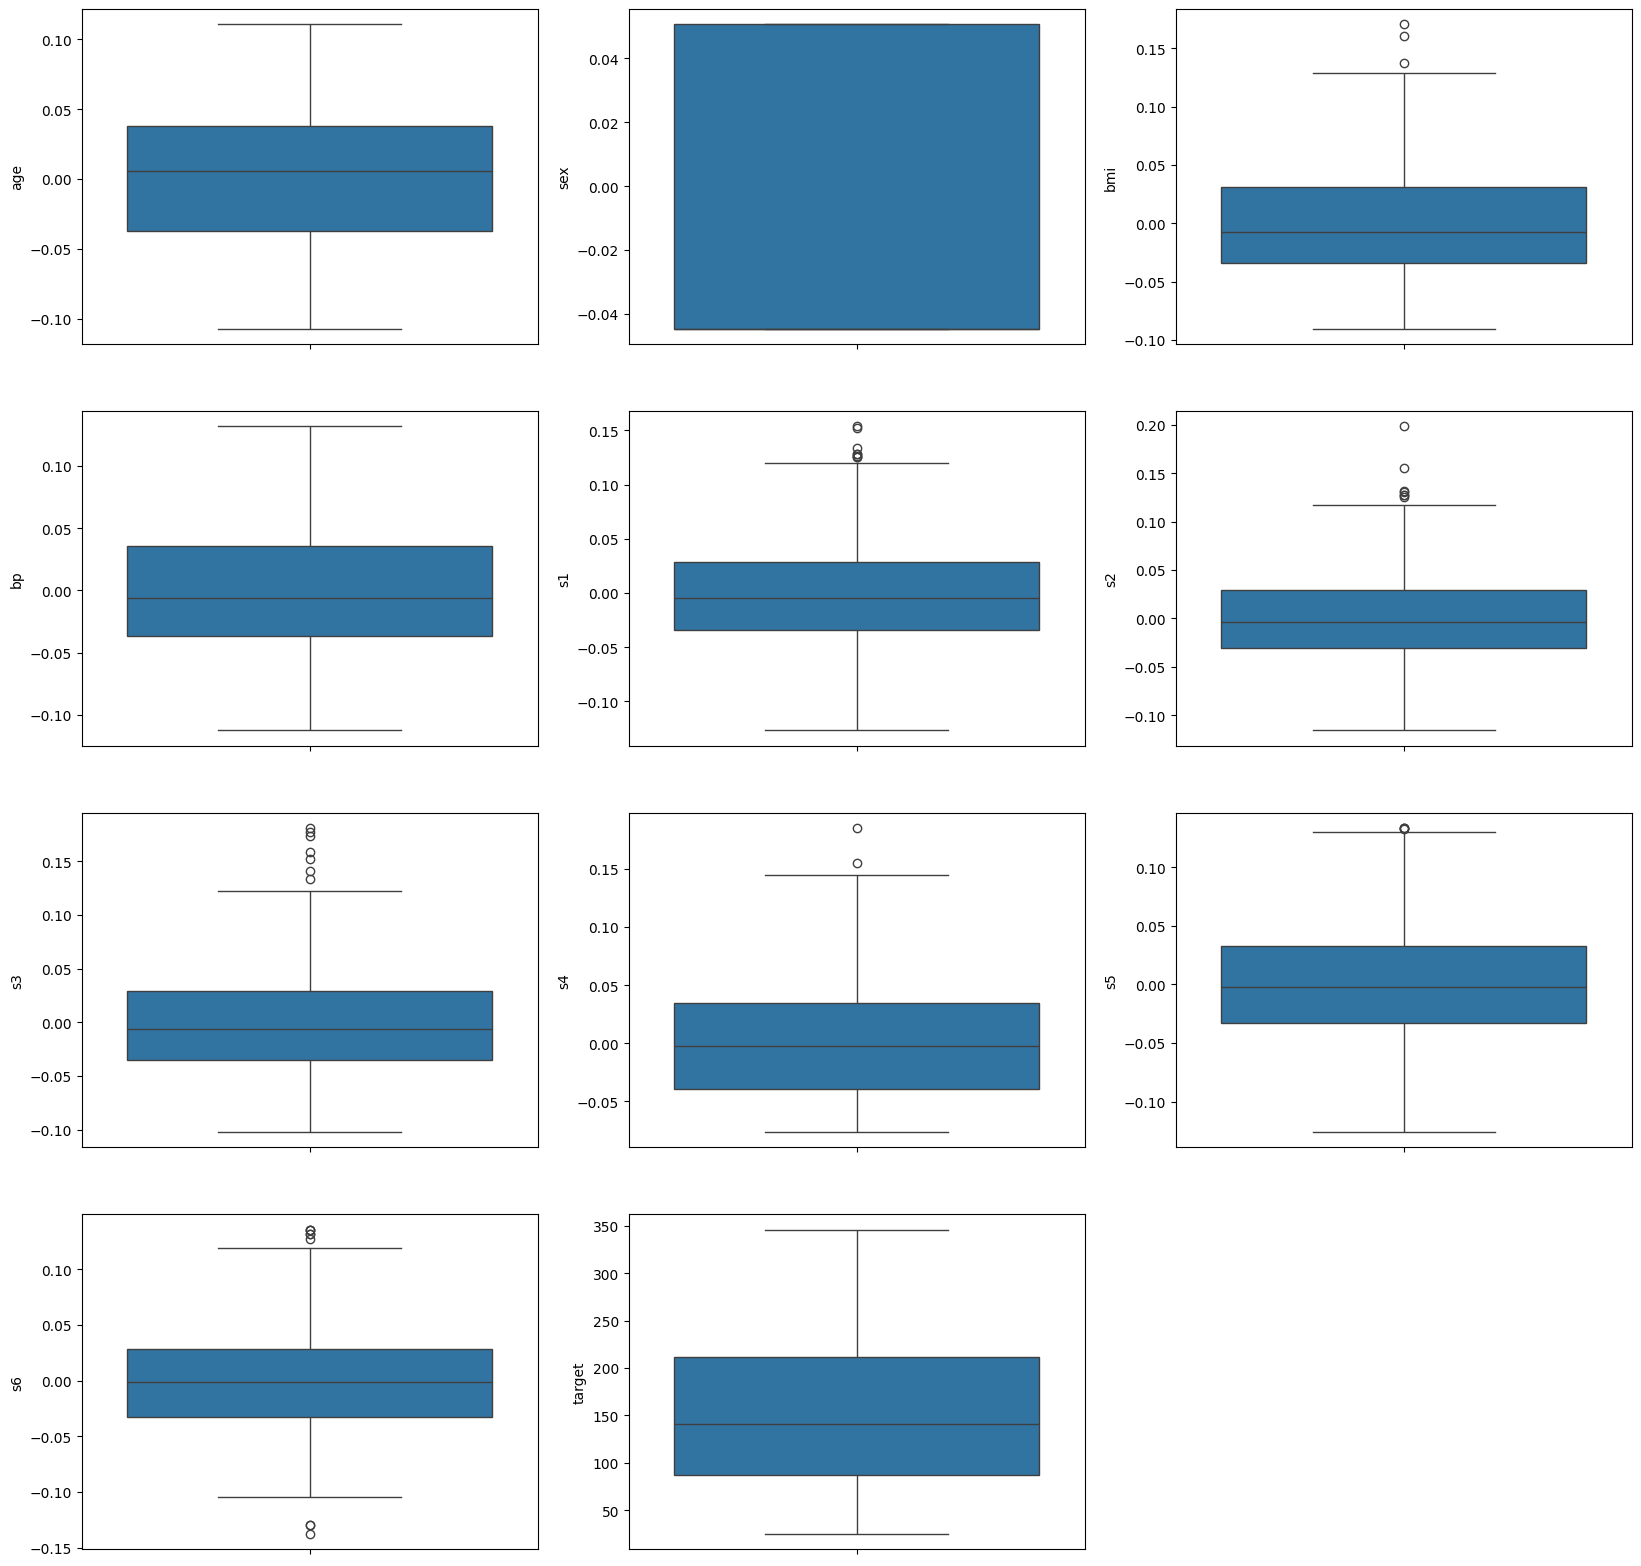

In [162]:
# Boxplot for each feature, to observe outliers
plt.figure(figsize=(20, 20))
for i, col in enumerate(df.columns):
    plt.subplot(4, 3, i+1)
    sns.boxplot(y=col, data=df)
plt.show()


We observe some outliers in the data

Let us create our features and label sets

In [163]:
#Crating the features and label sets

X_diabetes = df.drop('target', axis=1)
y_diabetes = df['target']

X_diabetes.head()
#y_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


We start building our models, starting with the most basic model

In [164]:
# Simple Linear Regression Model
model = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

In [165]:
# def check_model(model, x, y):

#     model.fit(x, y)
#     y_hat = model.predict(x) 

#     print('R^2:', model.score(x, y), 'MSE:', mean_squared_error(y_hat, y))

#     res = cross_val_score(model, x, y, cv=kf, scoring=mse)
#     cv_mse = np.mean(res)
#     res = cross_val_score(model, x, y, cv=kf)
#     cv_r2 = np.mean(res)

#     print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

In [166]:
def check_model(model, x, y, visualize=None):
    Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

    model.fit(Xtrain, ytrain)

    #check if model is lassoCV or ridgeCV
    if 'lassoCV' in model.named_steps:
        # print(model.named_steps['lassoCV'].coef_)
        print(f"Lambda: {model.named_steps['lassoCV'].alpha_}")

    if 'ridgeCV' in model.named_steps:
    #     print(model.named_steps['ridgeCV'].coef_)
        print(f"Lambda: {model.named_steps['ridgeCV'].alpha_}")

    ypredict = model.predict(Xtrain)

    # Print train model score R^2 to check overfitting
    print(f'R^2 for train: {model.score(Xtrain,ytrain)}') # Get R^2 using the original data

    # Print the train MSE for the model
    print(f'Train MSE: {mean_squared_error(ytrain, ypredict)}') # Get MSE using the test data

    #Print the test MAE for the model
    print(f'Train MAE: {mean_absolute_error(ytrain, ypredict)}')

    # Visualize the results
    if visualize is not None:
        plt.scatter(ytrain, ypredict)
        plt.xlabel('Train values')
        plt.ylabel('Predicted values')
        plt.show()

    ypredict = model.predict(Xtest)

    # Print test model score R^2 to check generalization
    print(f'R^2 for test: {model.score(Xtest,ytest)}') # Get R^2 using the test data
    
    # Print the test MSE for the model
    print(f'Test MSE: {mean_squared_error(ytest, ypredict)}') # Get MSE using the test data

    #Print the test MAE for the model
    print(f'Test MAE: {mean_absolute_error(ytest, ypredict)}')
          
    # Visualize the results
    if visualize is not None:
        plt.scatter(ytest, ypredict)
        plt.xlabel('Test values')
        plt.ylabel('Predicted values')
        plt.show()


check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.5279193863361498
Train MSE: 2868.549702835577
Train MAE: 43.483503523980396
R^2 for test: 0.45260276297191926
Test MSE: 2900.1936284934823
Test MAE: 42.79409467959994


In [167]:
# Polynomial regression with degree = 2
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression())
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.6061583502354677
Train MSE: 2393.138618059787
Train MAE: 39.14260998957739
R^2 for test: 0.4156399336408033
Test MSE: 3096.028307344255
Test MAE: 43.581693254652215


In [ ]:
# Polynomial regression with degree = 3
model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('reg', LinearRegression())
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.8772926910177228
Train MSE: 745.6184484785988
Train MAE: 18.68895848525861
R^2 for test: -14.561284890440422
Test MSE: 82446.04875145189
Test MAE: 164.8538973437784


We observe strong case of overfitting with degree = 3 for simple Polynomial regression models, let us introduce some Regularization techniques

Lasso :

In [169]:
# LR with Lasso and fixed Lambda
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01))
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.5279123910097061
Train MSE: 2868.5922092232795
Train MAE: 43.48405371578932
R^2 for test: 0.4529473377023646
Test MSE: 2898.368019282879
Test MAE: 42.79501773801213


In [170]:
# PR (degree = 2) with Lasso and fixed Lambda
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', Lasso(alpha=0.3))
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.587591659889711
Train MSE: 2505.957218384444
Train MAE: 39.96723871439328
R^2 for test: 0.5037387517673886
Test MSE: 2629.2674000446414
Test MAE: 39.540945575522116


In [171]:
# PR (degree = 4) with Lasso and fixed Lambda
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=4)),
    ('lasso', Lasso(alpha=15))
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.4409791405190019
Train MSE: 3396.833239767289
Train MAE: 48.275464034589426
R^2 for test: 0.29676963778349674
Test MSE: 3725.8211731873294
Test MAE: 49.98537724143344


With degree > 2, our model starts performing bad

In [172]:
# LR with LassoCV for automated Lambda 
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lassoCV', LassoCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 1.6552151706972245
R^2 for train: 0.5189598717616861
Train MSE: 2922.991279393155
Train MAE: 44.09677618307882
R^2 for test: 0.4714218340088624
Test MSE: 2800.487334373644
Test MAE: 42.79302879756627


In [173]:
# PR (degree = 2) with LassoCV 
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lassoCV', LassoCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 3.8237617258558765
R^2 for train: 0.523227348301008
Train MSE: 2897.0603934291607
Train MAE: 44.162135435195616
R^2 for test: 0.5074772023489613
Test MSE: 2609.4605215591387
Test MAE: 41.761502216833144


We observe better model performance with Lasso, as Train and Test R^2 begin to converge

Ridge:

In [174]:
# Simple LR with Ridge and fixed Lambda
model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1))
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.5276319768458045
Train MSE: 2870.2961172916243
Train MAE: 43.494721912937955
R^2 for test: 0.45414652070698225
Test MSE: 2892.0145657501726
Test MAE: 42.81199941834888


In [175]:
# PR (degree = 2) with Ridge and fixed Lambda
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge(alpha=10))
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.5905334498527841
Train MSE: 2488.0817316982084
Train MAE: 39.696542767515425
R^2 for test: 0.5016175218915184
Test MSE: 2640.5059978204886
Test MAE: 39.865643806668835


In [176]:
# PR (degree = 4) with Ridge and fixed Lambda
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=4)),
    ('ridge', Ridge(alpha=7000))
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.5014871600829615
Train MSE: 3029.1624299192104
Train MAE: 44.73489469549895
R^2 for test: 0.3222519304509758
Test MSE: 3590.8121197349137
Test MAE: 49.57046777433198


In [177]:
# LR with RidgeCV for automated Lambda 
model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridgeCV', RidgeCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 1.0
R^2 for train: 0.5276319768458042
Train MSE: 2870.296117291626
Train MAE: 43.494721912937386
R^2 for test: 0.45414652070699446
Test MSE: 2892.0145657501075
Test MAE: 42.81199941834904


In [178]:
# PR with RidgeCV for automated Lambda 
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridgeCV', RidgeCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 10.0
R^2 for train: 0.5905334498527831
Train MSE: 2488.081731698214
Train MAE: 39.69654276751602
R^2 for test: 0.5016175218915129
Test MSE: 2640.5059978205177
Test MAE: 39.865643806669006


We Observe LassoCV has better Performance than RidgeCV hence there is a need of feature selection in our data. Let us explicitly drop some columns based on multicollinearity and convert the categorical feature 'sex' and observe its effects.

Transforming the categorical variable 'sex' into numerical variable using one hot encoding

In [179]:
def reset_x_diabetes():
    X_diabetes = df.drop('target', axis=1)
    y_diabetes = df['target']

    X_diabetes = pd.get_dummies(X_diabetes, columns=['sex'])

    #apply lambda function to set values True to 1 and False to 0
    X_diabetes = X_diabetes.applymap(lambda x: 1.0 if x == True else x)
    X_diabetes = X_diabetes.applymap(lambda x: 0.0 if x == False else x)

    #rename sex_0.05068011873981862 column to sex_0.5
    X_diabetes = X_diabetes.rename(columns={"sex_0.05068011873981862": "sex_0.05", "sex_-0.044641636506989144": "sex_-0.04"})

    return X_diabetes

X_diabetes = reset_x_diabetes()

X_diabetes.head()

,age,bmi,bp,s1,s2,s3,s4,s5,s6,sex_-0.04,sex_0.05
0,0.038076,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,0.0,1.0
1,-0.001882,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,1.0,0.0
2,0.085299,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,0.0,1.0
3,-0.089063,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,1.0,0.0
4,0.005383,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,1.0,0.0


Calculating VIF to check multicollinearity

In [180]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

vif = calc_vif(X_diabetes)
vif

,variables,VIF
0,age,1.217307
1,bmi,1.509437
2,bp,1.459428
3,s1,59.202510
4,s2,39.193370
5,s3,15.402156
6,s4,8.890986
7,s5,10.075967
8,s6,1.484623
9,sex_-0.04,1.130228


Dropping features with high VIF values

In [181]:
X_diabetes = reset_x_diabetes()
X_diabetes = X_diabetes.drop(columns=['s1','s2'])
vif = calc_vif(X_diabetes)
vif

,variables,VIF
0,age,1.207546
1,bmi,1.486750
2,bp,1.454393
3,s3,2.430240
4,s4,3.154782
5,s5,1.975611
6,s6,1.484007
7,sex_-0.04,1.128652
8,sex_0.05,1.146054


In [182]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridgeCV', RidgeCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 10.0
R^2 for train: 0.5694021386795075
Train MSE: 2616.4839889232653
Train MAE: 41.18558003349814
R^2 for test: 0.5103273189611227
Test MSE: 2594.36017124694
Test MAE: 40.34416557532889


In [183]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lassoCV', LassoCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 2.515779882614544
R^2 for train: 0.5373990134660338
Train MSE: 2810.9477153797147
Train MAE: 43.36759132858605
R^2 for test: 0.5222089087271122
Test MSE: 2531.409705653106
Test MAE: 40.63436548166671


We start observing more convergence between train and test R^2 values after dropping highly collinear features s1 and s2, hence s1 and s2 does not explain any variation in the target variable

We can try to drop more features which have lower VIF using trial and error

In [184]:
X_diabetes = X_diabetes.drop(columns=['s3'])

model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lassoCV', LassoCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 2.0406266262691157
R^2 for train: 0.5253663095929981
Train MSE: 2884.0632132846617
Train MAE: 44.10747623747615
R^2 for test: 0.524900169988401
Test MSE: 2517.150995095893
Test MAE: 41.55907334691337


The R^2 scores are almost converged when we drop s3

In [185]:
X_diabetes = X_diabetes.drop(columns=['s5'])

model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lassoCV', LassoCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 1.5436592080041118
R^2 for train: 0.49657704113047474
Train MSE: 3058.998266965619
Train MAE: 45.16949812553629
R^2 for test: 0.44135119394310496
Test MSE: 2959.8061486170504
Test MAE: 45.063131059826496


After dropping s5, our model starts performing worse on unseen data, hence we only drop s1, s2 and s3

In [186]:
X_diabetes = reset_x_diabetes()
X_diabetes = X_diabetes.drop(columns=['s1', 's2', 's3'])

model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lassoCV', LassoCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 2.0406266262691157
R^2 for train: 0.5253663095929981
Train MSE: 2884.0632132846617
Train MAE: 44.10747623747615
R^2 for test: 0.524900169988401
Test MSE: 2517.150995095893
Test MAE: 41.55907334691337


For feature engineering we can perform PCA to automatically create best features which explain majority variation in the target variable

PCA

In [187]:
model = Pipeline([
    ('pca', PCA(n_components=5)),
    ('reg', LinearRegression())
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.4898786895900198
Train MSE: 3099.700116956312
Train MAE: 45.4668058410763
R^2 for test: 0.45989641036211426
Test MSE: 2861.550777820057
Test MAE: 44.31960351783554


In [188]:
model = Pipeline([
    ('pca', PCA(n_components=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression())
])

check_model(model, X_diabetes, y_diabetes)

R^2 for train: 0.5291046907909966
Train MSE: 2861.347321201364
Train MAE: 43.65501003932643
R^2 for test: 0.5303557918046669
Test MSE: 2488.2462828307994
Test MAE: 40.316803742590224


This is by far our best model, in terms of performance and complexity

We observe that thes model performs better on unseen data with higher test r^2 score than train r^2 score

This model is not very complex (Polynomial Regression with degree = 2)


Now let us check the effect of regularization in our model

In [189]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('lassoCV', LassoCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 1.7462524561803148
R^2 for train: 0.5219904099872051
Train MSE: 2904.5765229413373
Train MAE: 44.04862990783083
R^2 for test: 0.517459075747531
Test MSE: 2556.5750415590355
Test MAE: 41.45020862218208


In [190]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridgeCV', RidgeCV())
])

check_model(model, X_diabetes, y_diabetes)

Lambda: 10.0
R^2 for train: 0.5295222679851403
Train MSE: 2858.8099559686016
Train MAE: 43.684043137377046
R^2 for test: 0.5284711312238642
Test MSE: 2498.231500582339
Test MAE: 40.53218066273707


We observe negligible or even negative change in the r^2 scores after regularization suggesting no overfitting in our best model and no need for feature selection after PCA

Finally we plot the scatter plot between train, test and predicted labels for our best model

R^2 for train: 0.5291046907909966
Train MSE: 2861.347321201364
Train MAE: 43.65501003932643


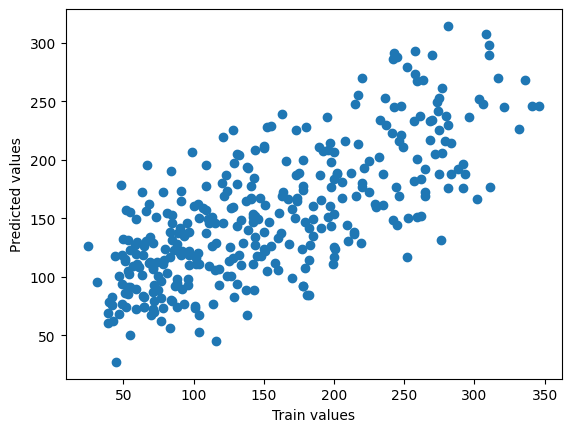

R^2 for test: 0.5303557918046669
Test MSE: 2488.2462828307994
Test MAE: 40.316803742590224


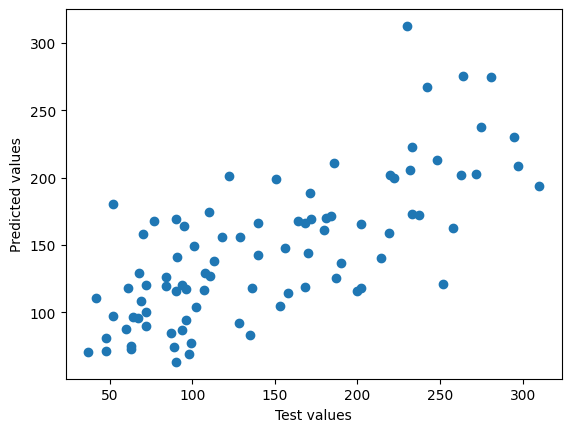

In [191]:
model = Pipeline([
    ('pca', PCA(n_components=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression())
])

check_model(model, X_diabetes, y_diabetes, 1)

Visually we observe a similar trend between out train vs predicted (prediction with training data) and test vs predicted graph (prediction with unseen data)